In [6]:
# load the sentence-bert model from the HuggingFace model hub
#!pip install transformers
import matplotlib.pyplot as plt

In [19]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from torch.nn import functional as F
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-mpnet-base-v2')
tokenizer = AutoTokenizer.from_pretrained('deepset/sentence_bert')
model = AutoModel.from_pretrained('deepset/sentence_bert')

Some weights of the model checkpoint at deepset/sentence_bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
from transformers import pipeline

classifier = pipeline("text-classification", model = "cross-encoder/qnli-electra-base")

# Simple encoding with BERT

In [5]:
def BERTCosinePrediction(sentences, labels):
    predictions = []
    for sentence, labelled_class in sentences.items():
        sentence_embed = tokenizer.encode("questions are easily understandable",return_tensors='pt', padding='max_length', max_length=100)
        labels_embed = []
        for label in labels:
            label_embed = []
            cosine_with_each_label = []
            for l in label:
                l_embed = tokenizer.encode(l,return_tensors='pt', padding='max_length', max_length=100)
                label_embed.append(l_embed)
                cosine_with_each_label.append(F.cosine_similarity(sentence_embed.float(), l_embed.float()))

            max_cosine = max(cosine_with_each_label)
            avg_cosine = sum(cosine_with_each_label)/len(cosine_with_each_label)

            label_avg_embedding = torch.empty(100)
            for embed in label_embed:
                label_avg_embedding = label_avg_embedding + embed

            label_avg_embedding = label_avg_embedding/len(label_embed)
            cosine_oftheavglabels = F.cosine_similarity(sentence_embed.float(), label_avg_embedding)
            
            labels_embed.append(avg_cosine)
            
        # prediction
        prediction = [1 if (y>.75 and y==max(labels_embed))else 0 for y in labels_embed]
        if 1 in prediction:
            prediction.append(0)
        else:
            prediction.append(1)

        # append the predicted class to the prediction list
        predictions.append(prediction.index(1)+1)
    return predictions
    
            

# Cosine similarity with BERT sentence encoding

In [20]:
# it takes input as a json of sentences and a list of labels as [<list of keywords for label 1>, <>, ..]
# it ouputs a list of encoding objects -> {
#             "sentence": sentence,
#             "encodings": {
#                 "label": label,
#                 "sentence_rep":sentence_rep,
#                 "label_reps":label_reps
#             }}

def BERTencoding(sentences,labels):
    sentence_net = []
    for sentence, labelled_class in sentences.items():
        encodings =[]
        for label in labels:
            # run inputs through model and mean-pool over the sequence
            # dimension to get sequence-level representations
            inputs = tokenizer.batch_encode_plus([sentence] + label,
                                                 return_tensors='pt',
                                                 pad_to_max_length=True)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']
            output = model(input_ids, attention_mask=attention_mask)[0]
            sentence_rep = output[:1].mean(dim=1)
            label_reps = output[1:].mean(dim=1)
            
            encodings.append({
                "label": label,
                "sentence_rep":sentence_rep,
                "label_reps":label_reps
            })

        #binding to the output
        sentence_net.append({
            "sentence": sentence,
            "encodings": encodings
            })
    return sentence_net

In [7]:
# takes input the json of the output of BERTencoding list of objects and threshold -> cutoff similarity for a class
# Outputs the list of predictions
def cosineSimilarity(sentence_net, threshold):
    predictions =[]
    for sentence in sentence_net:
        print("----------Sentence similarity for : ",sentence["sentence"])
        labels_similarity = []
        for encoding in sentence["encodings"]:
            label = encoding["label"]
            print("--- Class labels : ", label)
            # now find the labels with the highest cosine similarities to
            # the sentence
            similarities = F.cosine_similarity(encoding["sentence_rep"], encoding["label_reps"])
            closest = similarities.argsort(descending=True)
            similarity_list = []
            for ind in closest:
                print(f'label: {label[ind]} \t similarity: {similarities[ind]}')
                similarity_list.append(float(similarities[ind]))

            # plotting the graph to show similarity with all the labels
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            ax.bar(label,similarity_list)
            plt.show()

            # getting the mean similarity for each label
            print("Mean similarity :", np.mean(similarity_list))
            labels_similarity.append(np.mean(similarity_list))    
            print("\n")

        # getting the predicted class
        print(labels_similarity)
        predicted_labels = [1 if (y>threshold and y==max(labels_similarity))else 0 for y in labels_similarity]
        if 1 in predicted_labels:
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)

        # append the predicted class to the prediction list
        predictions.append(predicted_labels.index(1)+1)
        print("Predicted class : ", predicted_labels.index(1)+1)
        print("------------------------------------------------------")
    return predictions

# BERT sentence classification using cross encoder (pretrained)

In [8]:
def BERTCrossEncoder(sentences, labels, stat=None):
    predictions = []
    for sentence in sentences:
        print("Sentence --> " + sentence)
        label_max = []
        for label in labels:
            score_max = []
            for l in label:
                c = classifier(sentence+" , "+l)
                print(l, c)
                score_max.append(c[0]['score'])
                
            if stat == "MEAN":
                label_max.append(np.mean(score_max))
            elif stat == "MEDIAN":
                label_max.append(np.median(score_max))
            elif stat == "MAX":
                label_max.append(max(score_max))
            else:
                label_max.append(np.mean(score_max)+np.median(score_max)+max(score_max))
                
        print(label_max)
        if max(label_max)<.75:
            predictions.append(4)
        else:
            predictions.append(label_max.index(max(label_max))+1)
    return predictions

In [9]:
# takes list of predictions and labels
def evaluation(class_labels, predictions):
    labels = [1,2,3,4] 
    print("Accuracy ",accuracy_score(class_labels, predictions))
    print(classification_report(class_labels, predictions, labels=[1,2,3,4])) #classification report from sklearn
    cnf_matrix = confusion_matrix(class_labels, predictions, labels=labels)
    plt.imshow(cnf_matrix, cmap=plt.cm.Blues) #plot confusion matrix grid
    threshold = cnf_matrix.max() / 2 #threshold to define text color
    for i in range(cnf_matrix.shape[0]): #print text in grid
        for j in range(cnf_matrix.shape[1]): 
            plt.text(j, i, cnf_matrix[i,j], color="w" if cnf_matrix[i,j] > threshold else 'black')
    tick_marks = np.arange(len(labels)) #define labeling spacing based on number of classes
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()

# Revenue Question

In [15]:
sentences = {'Annual recurring revenue':4, 
             'paying members':2,
             'Total income':4,
             'Margins':4,
             'Monthly recurring revenue':4,
             'Total revenue':4,
             'Recurring revenue':4,
             'Profits':4,
             'average expenditure per user':1,
             'revenue per user':1,
             'average monthly revenue from each user':1,
             'number of new subscribers per month':2,
             'estimated initial customers':2,
             'number of new paying members':2,
             'average customer retention':3,
             'projected users subscription length':3
            }

In [16]:
label1 = ['Monthly fee','Fee per user','Charge','Cost','Average revenue per user','Recurring monthly fee','Fee charged per user','Monthly service charge','User fee','Monthly subscription fee']
label2 = ['users','Subscribers','Customers','clients','patrons','payees','members']
label3 = ['Average lifetime','lifespan','Duration subscription','Churn','Attrition','churn rate','Churn analysis','Churn prediction','Churn prevention','Reducing churn','Increasing retention','retention rate','Customer attrition rate','Attrition analysis','Attrition prediction','Attrition prevention']

In [17]:
label1 = ['Monthly fee','Fee per user ','Charge','Cost','Average revenue per user','Monthly payment','Recurring monthly charge','Monthly service fee','Monthly access fee','Monthly maintenance fee','Membership fee','Subscription fee','Dues','charge per user','fee per user']
label2 = ['users','Subscribers','Customers','clients','patrons','payees','members','number of people using the service','number of users of the service','amount of people using the service','how many people are using the service','how popular is the service','how many users does the service have','is the service used by a lot of people','how well-known is the service','what is the user base for the service','how big is the market for the service']
label3 = ['Average customer lifetime','Customer lifespan','Duration of subscription','Churn','Attrition','employee turnover','Attrition rates','Average customer lifetime value','Average length of customer life cycle','Average time customers remain active','Customer attrition rate over time','How long do customers stay on average?','What is the typical lifespan of a customer?','staff turnover','Average client lifetime','Median customer lifetime','Ordinary customer lifetime']


In [18]:
labels = [label1, label2, label3]
class_labels = []
for key, value in sentences.items():
    class_labels.append(value)

/opt/homebrew/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


----------Sentence similarity for :  Annual recurring revenue
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Recurring monthly charge 	 similarity: 0.8132507801055908
label: Monthly payment 	 similarity: 0.7136096358299255
label: Monthly maintenance fee 	 similarity: 0.60569167137146
label: Monthly fee 	 similarity: 0.5823222398757935
label: Average revenue per user 	 similarity: 0.5798895359039307
label: Monthly service fee 	 similarity: 0.5797783732414246
label: Monthly access fee 	 similarity: 0.5618972182273865
label: Dues 	 similarity: 0.5132138133049011
label: Cost 	 similarity: 0.43966183066368103
label: fee per user 	 similarity: 0.37991517782211304
label: Fee per user  	 similarity: 0.37991517782211304
label: Subscription 

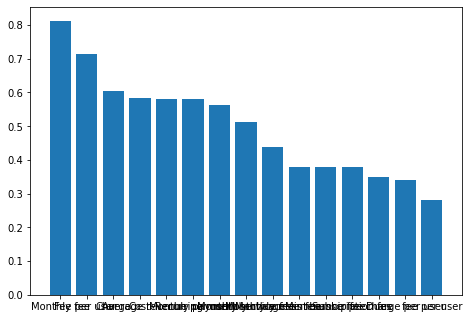

Mean similarity : 0.49975104530652364


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.5551793575286865
label: Subscribers 	 similarity: 0.48747897148132324
label: clients 	 similarity: 0.3581876754760742
label: amount of people using the service 	 similarity: 0.3431164026260376
label: members 	 similarity: 0.3152749240398407
label: how many people are using the service 	 similarity: 0.3059542179107666
label: users 	 similarity: 0.3018260896205902
label: how many users does the service have 	 similarity: 0.30151039361953735
label: n

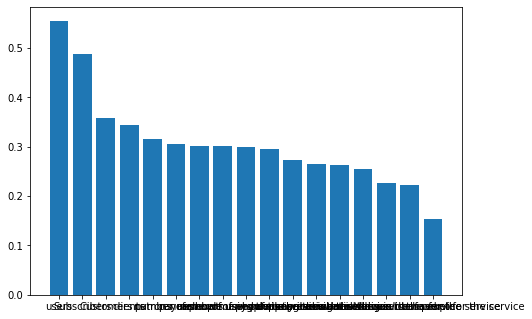

Mean similarity : 0.3069479658323176


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.5333137512207031
label: employee turnover 	 similarity: 0.5096274018287659
label: Duration of subscription 	 similarity: 0.5002707242965698
label: Average customer lifetime 	 similarity: 0.49536556005477905
label: Customer lifespan 	 similarity: 0.4922361671924591
label: Average time customers remain active 	 similarity: 0.4865691661834717
label: Average client lifetime 	 similarity: 0.48652619123

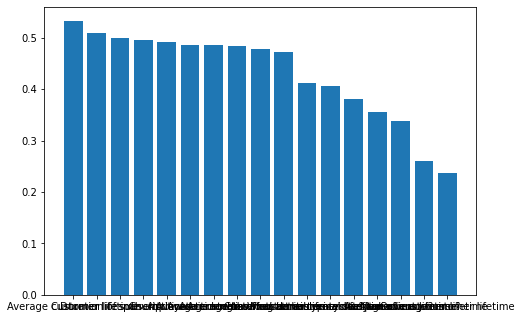

Mean similarity : 0.430906082777416


[0.49975104530652364, 0.3069479658323176, 0.430906082777416]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  paying members
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Membership fee 	 similarity: 0.6059747338294983
label: Monthly service fee 	 similarity: 0.5998821258544922
label: Monthly payment 	 similarity: 0.5907884836196899
label: Monthly fee 	 similarity: 0.5619964599609375
label: Monthly access fee 	 similarity: 0.5551061630249023
label: fee per user 	 similarity: 0.551837682723999
label: Fee per user  	 similarity: 0.551837682723999
label: Average revenue per user 	 similarity: 0.5396603941917419
label: Subscription fe

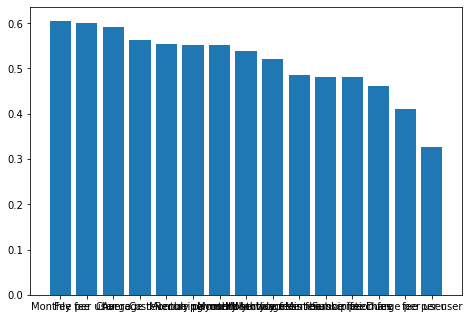

Mean similarity : 0.5152156710624695


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.6933776140213013
label: Subscribers 	 similarity: 0.6510391235351562
label: clients 	 similarity: 0.5314223170280457
label: members 	 similarity: 0.5144422650337219
label: Customers 	 similarity: 0.49930450320243835
label: patrons 	 similarity: 0.49377748370170593
label: amount of people using the service 	 similarity: 0.47789496183395386
label: is the service used by a lot of people 	 similarity: 0.4531715214252472
label: users 	 similarity: 0.443

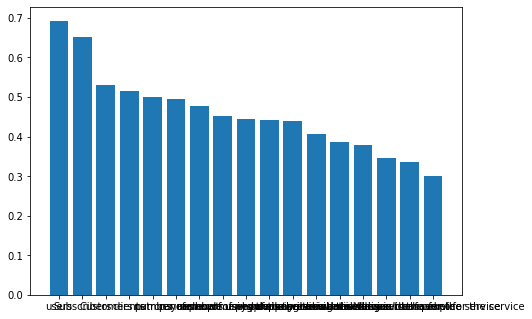

Mean similarity : 0.45835406639996695


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average client lifetime 	 similarity: 0.5417932271957397
label: Average customer lifetime value 	 similarity: 0.525442898273468
label: employee turnover 	 similarity: 0.5048255920410156
label: Average customer lifetime 	 similarity: 0.4939102828502655
label: Customer lifespan 	 similarity: 0.4843786954879761
label: Customer attrition rate over time 	 similarity: 0.47242212295532227
label: staff turnover 	 similarity: 0.471566379070282
label: M

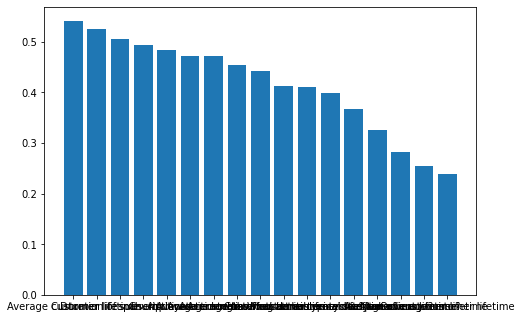

Mean similarity : 0.41643284173572764


[0.5152156710624695, 0.45835406639996695, 0.41643284173572764]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  Total income
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.6851227879524231
label: Cost 	 similarity: 0.5663249492645264
label: Monthly payment 	 similarity: 0.5445876717567444
label: Dues 	 similarity: 0.49710679054260254
label: Monthly service fee 	 similarity: 0.49170076847076416
label: Monthly access fee 	 similarity: 0.46193549036979675
label: Subscription fee 	 similarity: 0.44947001338005066
label: Monthly fee 	 similarity: 0.44727906584739685
label: Recurring monthly cha

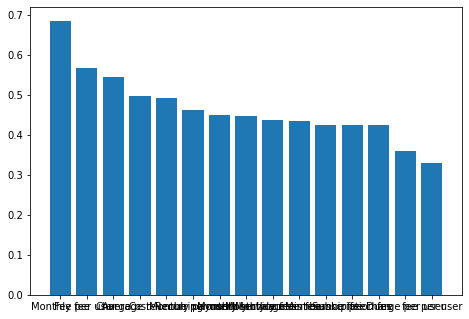

Mean similarity : 0.46473684112230934


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.5619500279426575
label: Subscribers 	 similarity: 0.4913853108882904
label: amount of people using the service 	 similarity: 0.3693755269050598
label: number of users of the service 	 similarity: 0.35358119010925293
label: members 	 similarity: 0.3432176411151886
label: number of people using the service 	 similarity: 0.336511492729187
label: clients 	 similarity: 0.3324865698814392
label: how many people are using the service 	 similarity: 0.3070

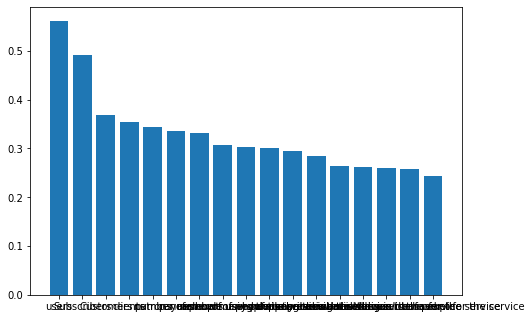

Mean similarity : 0.3274142961291706


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.6083070039749146
label: Median customer lifetime 	 similarity: 0.5540191531181335
label: Average customer lifetime 	 similarity: 0.5188536047935486
label: Average client lifetime 	 similarity: 0.5165359973907471
label: Duration of subscription 	 similarity: 0.4830288290977478
label: Attrition rates 	 similarity: 0.4557250738143921
label: Average length of customer life cycle 	 similarity: 0.427726

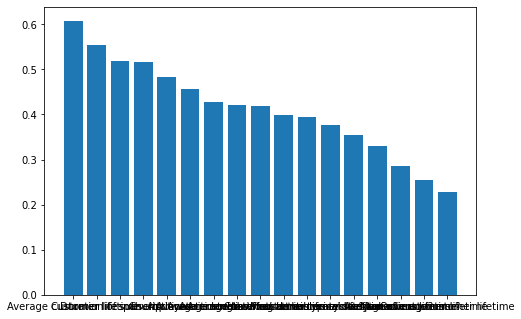

Mean similarity : 0.41314440965652466


[0.46473684112230934, 0.3274142961291706, 0.41314440965652466]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  Margins
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Cost 	 similarity: 0.5301655530929565
label: Dues 	 similarity: 0.3366434574127197
label: Average revenue per user 	 similarity: 0.3292166590690613
label: Subscription fee 	 similarity: 0.29817232489585876
label: Charge 	 similarity: 0.2888683080673218
label: Monthly service fee 	 similarity: 0.2862299680709839
label: Monthly payment 	 similarity: 0.27119705080986023
label: fee per user 	 similarity: 0.2672194838523865
label: Fee per user  	 similarity: 0.2672194838

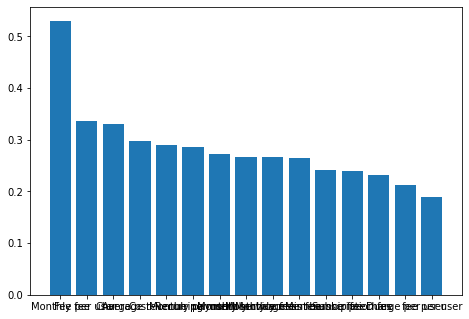

Mean similarity : 0.2834842473268509


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: members 	 similarity: 0.37879469990730286
label: users 	 similarity: 0.3373352587223053
label: patrons 	 similarity: 0.3331662118434906
label: payees 	 similarity: 0.2812705934047699
label: Customers 	 similarity: 0.26687613129615784
label: Subscribers 	 similarity: 0.2414189577102661
label: clients 	 similarity: 0.23926101624965668
label: number of users of the service 	 similarity: 0.18083468079566956
label: amount of people using the service 	 similarity: 0.1735862344

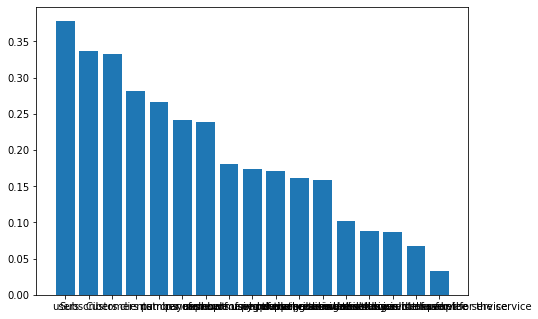

Mean similarity : 0.19413408461739035


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Duration of subscription 	 similarity: 0.3277420401573181
label: Attrition 	 similarity: 0.3097879886627197
label: Attrition rates 	 similarity: 0.2986520528793335
label: Median customer lifetime 	 similarity: 0.28363004326820374
label: Average customer lifetime value 	 similarity: 0.2791900038719177
label: Average time customers remain active 	 similarity: 0.27420878410339355
label: Ordinary customer lifetime 	 similarity: 0.25868678092956543

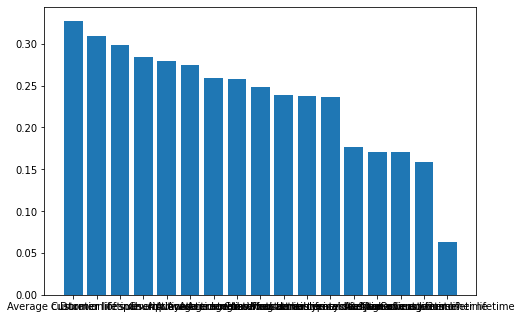

Mean similarity : 0.23481379098751964


[0.2834842473268509, 0.19413408461739035, 0.23481379098751964]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  Monthly recurring revenue
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Recurring monthly charge 	 similarity: 0.8419857621192932
label: Monthly payment 	 similarity: 0.7640399932861328
label: Monthly maintenance fee 	 similarity: 0.6404533386230469
label: Monthly fee 	 similarity: 0.6325122714042664
label: Monthly service fee 	 similarity: 0.6161381006240845
label: Monthly access fee 	 similarity: 0.605097770690918
label: Average revenue per user 	 similarity: 0.5591802597045898
label: Dues 	 similarity: 0.48585483431

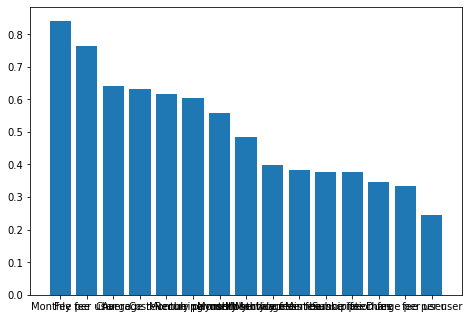

Mean similarity : 0.506894118587176


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.5422905683517456
label: Subscribers 	 similarity: 0.5052605867385864
label: clients 	 similarity: 0.3378722667694092
label: amount of people using the service 	 similarity: 0.32517778873443604
label: members 	 similarity: 0.30728986859321594
label: how many people are using the service 	 similarity: 0.29800277948379517
label: how many users does the service have 	 similarity: 0.29689979553222656
label: number of users of the service 	 similarity: 0.

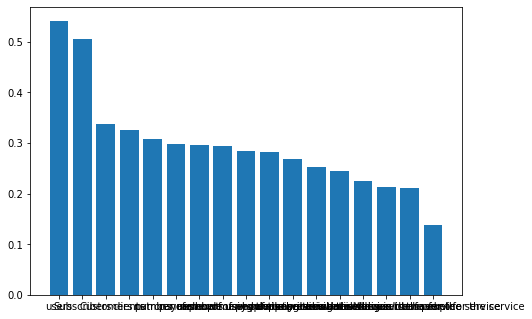

Mean similarity : 0.2957017316537745


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.5338045358657837
label: Average customer lifetime 	 similarity: 0.5201257467269897
label: Duration of subscription 	 similarity: 0.5111244916915894
label: Median customer lifetime 	 similarity: 0.5070961713790894
label: Average client lifetime 	 similarity: 0.5049998760223389
label: Customer lifespan 	 similarity: 0.5035293698310852
label: Average time customers remain active 	 similarity: 0.48725

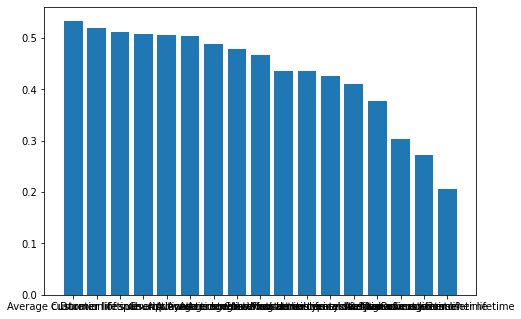

Mean similarity : 0.4340641454738729


[0.506894118587176, 0.2957017316537745, 0.4340641454738729]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  Total revenue
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.7542837262153625
label: Monthly payment 	 similarity: 0.5466596484184265
label: Cost 	 similarity: 0.5398095846176147
label: Monthly service fee 	 similarity: 0.5251279473304749
label: Monthly fee 	 similarity: 0.5123128890991211
label: Recurring monthly charge 	 similarity: 0.4973291754722595
label: Dues 	 similarity: 0.4923863708972931
label: Monthly access fee 	 similarity: 0.4909653067588806
label: charge per user 	 sim

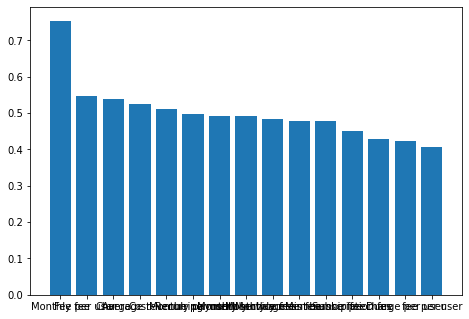

Mean similarity : 0.5003408233324687


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.5179035663604736
label: Subscribers 	 similarity: 0.5033218860626221
label: clients 	 similarity: 0.40357208251953125
label: amount of people using the service 	 similarity: 0.39765429496765137
label: users 	 similarity: 0.38670992851257324
label: number of users of the service 	 similarity: 0.381025493144989
label: patrons 	 similarity: 0.3809719681739807
label: members 	 similarity: 0.3738366961479187
label: number of people using the service 	 s

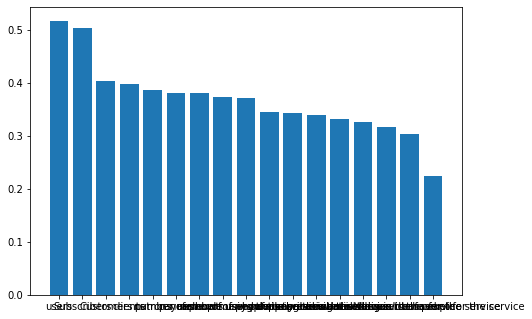

Mean similarity : 0.3673764844151104


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.5554131269454956
label: Average customer lifetime 	 similarity: 0.4881235957145691
label: Average client lifetime 	 similarity: 0.46609747409820557
label: Median customer lifetime 	 similarity: 0.46571680903434753
label: employee turnover 	 similarity: 0.43956613540649414
label: Duration of subscription 	 similarity: 0.43046334385871887
label: Attrition rates 	 similarity: 0.4274025559425354
label

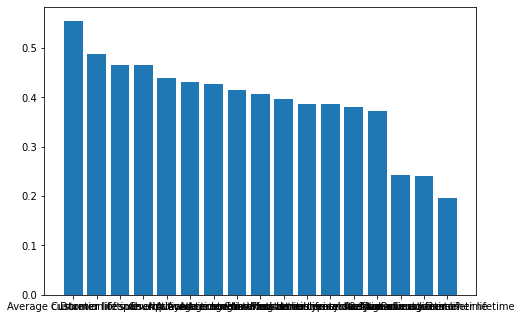

Mean similarity : 0.3938754577847088


[0.5003408233324687, 0.3673764844151104, 0.3938754577847088]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  Recurring revenue
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Recurring monthly charge 	 similarity: 0.740055501461029
label: Monthly payment 	 similarity: 0.6361934542655945
label: Average revenue per user 	 similarity: 0.5990590453147888
label: Monthly maintenance fee 	 similarity: 0.5538786053657532
label: Monthly service fee 	 similarity: 0.5455334186553955
label: Monthly fee 	 similarity: 0.5305426716804504
label: Dues 	 similarity: 0.5096096396446228
label: Monthly access fee 	 similarity: 0.5036671161651611
label

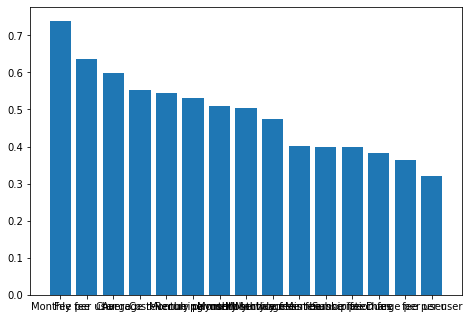

Mean similarity : 0.4905775507291158


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: payees 	 similarity: 0.5734162330627441
label: Subscribers 	 similarity: 0.49102991819381714
label: clients 	 similarity: 0.41282251477241516
label: members 	 similarity: 0.3519326448440552
label: amount of people using the service 	 similarity: 0.3306531012058258
label: users 	 similarity: 0.33018991351127625
label: patrons 	 similarity: 0.32866525650024414
label: Customers 	 similarity: 0.32046273350715637
label: number of people using the service 	 similarity: 0.28928

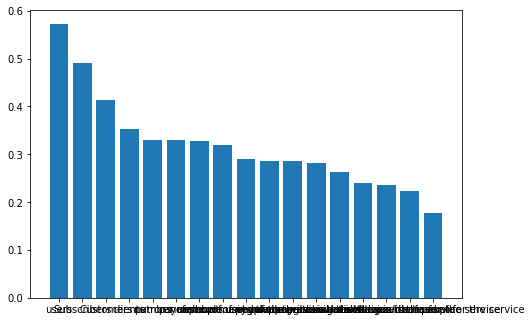

Mean similarity : 0.3189806534963496


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.520097017288208
label: Duration of subscription 	 similarity: 0.4966776967048645
label: employee turnover 	 similarity: 0.4853096902370453
label: Customer lifespan 	 similarity: 0.4826068580150604
label: Average time customers remain active 	 similarity: 0.48141685128211975
label: Average customer lifetime 	 similarity: 0.4661792516708374
label: Average client lifetime 	 similarity: 0.464758038520

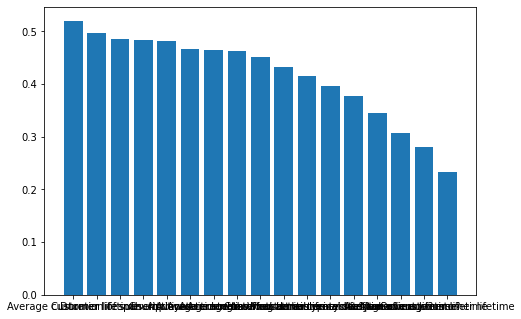

Mean similarity : 0.41737774891011853


[0.4905775507291158, 0.3189806534963496, 0.41737774891011853]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  Profits
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.6084880828857422
label: Cost 	 similarity: 0.4888351857662201
label: Monthly payment 	 similarity: 0.449950635433197
label: Monthly service fee 	 similarity: 0.43222343921661377
label: Recurring monthly charge 	 similarity: 0.4261176586151123
label: Monthly fee 	 similarity: 0.4067360758781433
label: Fee per user  	 similarity: 0.4062747657299042
label: fee per user 	 similarity: 0.4062747657299042
label: charge per user 	 sim

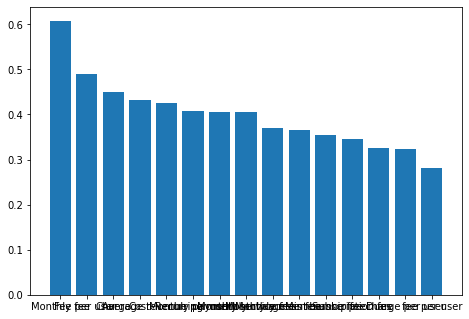

Mean similarity : 0.3994080980618795


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: how popular is the service 	 similarity: 0.38878104090690613
label: payees 	 similarity: 0.3826035261154175
label: patrons 	 similarity: 0.35218682885169983
label: clients 	 similarity: 0.32630401849746704
label: Subscribers 	 similarity: 0.32409003376960754
label: Customers 	 similarity: 0.3074333667755127
label: how well-known is the service 	 similarity: 0.28481394052505493
label: users 	 similarity: 0.2822257876396179
label: members 	 similarity: 0.27114424109458923


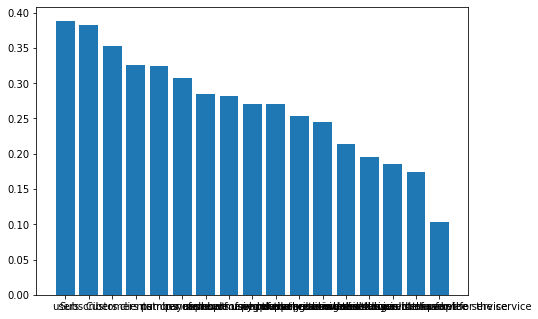

Mean similarity : 0.26833969442283406


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.5248084664344788
label: employee turnover 	 similarity: 0.5083978772163391
label: Customer attrition rate over time 	 similarity: 0.42605459690093994
label: Median customer lifetime 	 similarity: 0.42487725615501404
label: Average customer lifetime 	 similarity: 0.4237557649612427
label: staff turnover 	 similarity: 0.4044070839881897
label: Average client lifetime 	 similarity: 0.389013588428497

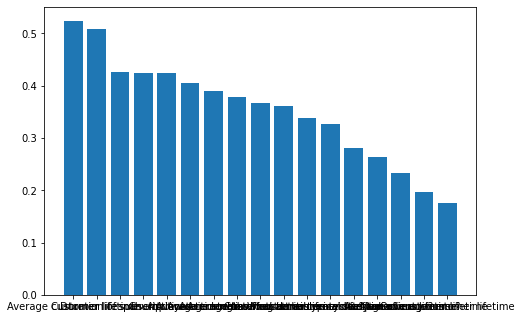

Mean similarity : 0.3543655521729413


[0.3994080980618795, 0.26833969442283406, 0.3543655521729413]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  average expenditure per user
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.8387468457221985
label: fee per user 	 similarity: 0.6107070446014404
label: Fee per user  	 similarity: 0.6107070446014404
label: Monthly service fee 	 similarity: 0.5764334797859192
label: Cost 	 similarity: 0.5653753876686096
label: Monthly access fee 	 similarity: 0.523399293422699
label: Monthly fee 	 similarity: 0.511529803276062
label: charge per user 	 similarity: 0.5110594034194946
label: Monthly m

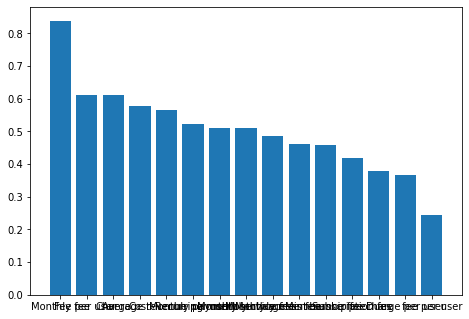

Mean similarity : 0.503933780392011


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.4553441107273102
label: amount of people using the service 	 similarity: 0.45192232728004456
label: payees 	 similarity: 0.42985284328460693
label: users 	 similarity: 0.42873671650886536
label: number of people using the service 	 similarity: 0.3928232491016388
label: number of users of the service 	 similarity: 0.3836960196495056
label: how many people are using the service 	 similarity: 0.37990936636924744
label: is the service used by a lot

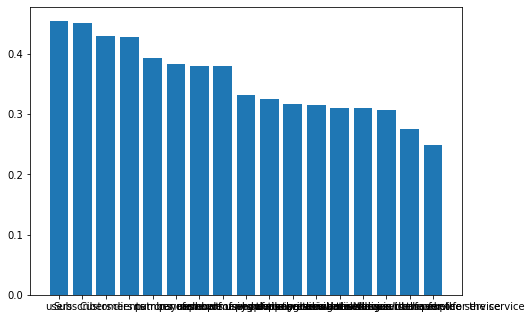

Mean similarity : 0.35529905908248005


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.6853933930397034
label: Average length of customer life cycle 	 similarity: 0.6808182001113892
label: Average customer lifetime 	 similarity: 0.6515561938285828
label: Median customer lifetime 	 similarity: 0.6337041854858398
label: Average client lifetime 	 similarity: 0.6165231466293335
label: Ordinary customer lifetime 	 similarity: 0.5251167416572571
label: Average time customers remain activ

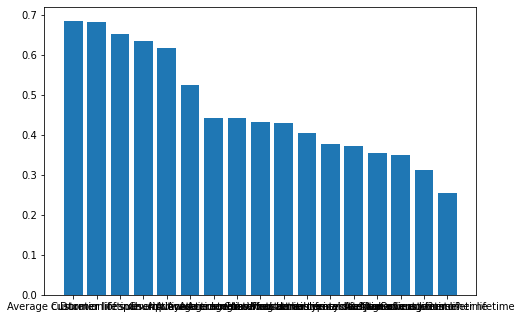

Mean similarity : 0.4685064186068142


[0.503933780392011, 0.35529905908248005, 0.4685064186068142]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  revenue per user
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.8712942600250244
label: fee per user 	 similarity: 0.6892563104629517
label: Fee per user  	 similarity: 0.6892563104629517
label: Monthly service fee 	 similarity: 0.6542795896530151
label: charge per user 	 similarity: 0.6426032185554504
label: Cost 	 similarity: 0.57242751121521
label: Monthly access fee 	 similarity: 0.5710892677307129
label: Monthly fee 	 similarity: 0.5646933913230896
label: Monthly payment 	 simi

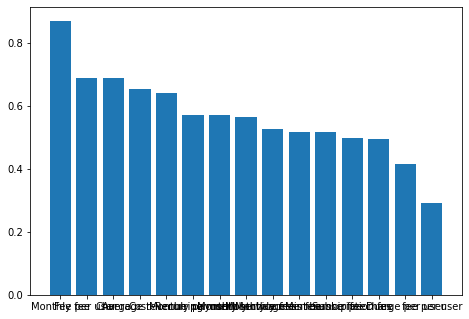

Mean similarity : 0.5679169575373332


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.5165342092514038
label: amount of people using the service 	 similarity: 0.5103800892829895
label: number of users of the service 	 similarity: 0.4905621111392975
label: users 	 similarity: 0.4869705140590668
label: payees 	 similarity: 0.4858967065811157
label: how many users does the service have 	 similarity: 0.4756794273853302
label: number of people using the service 	 similarity: 0.47364088892936707
label: how many people are using the s

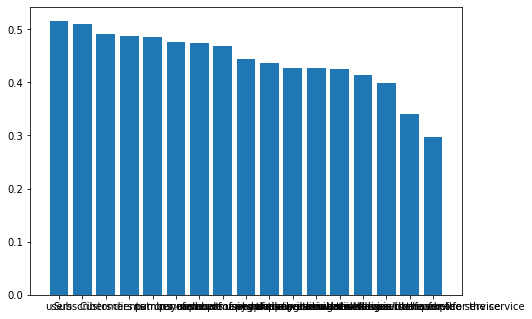

Mean similarity : 0.44249555293251486


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.6000085473060608
label: Customer attrition rate over time 	 similarity: 0.5422699451446533
label: employee turnover 	 similarity: 0.5374279618263245
label: Average customer lifetime 	 similarity: 0.5318489670753479
label: Median customer lifetime 	 similarity: 0.49906089901924133
label: Customer lifespan 	 similarity: 0.48959124088287354
label: Average client lifetime 	 similarity: 0.484908312559

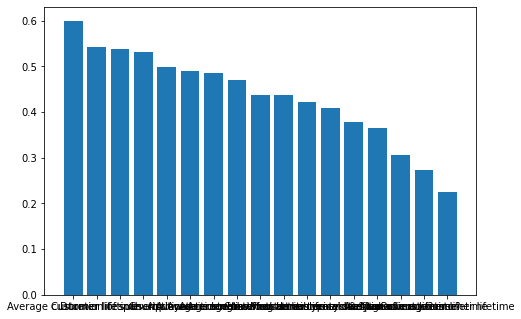

Mean similarity : 0.4353575101670097


[0.5679169575373332, 0.44249555293251486, 0.4353575101670097]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  average monthly revenue from each user
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.8406980037689209
label: Monthly service fee 	 similarity: 0.7052724957466125
label: Monthly access fee 	 similarity: 0.6730808615684509
label: Monthly payment 	 similarity: 0.66673743724823
label: Monthly fee 	 similarity: 0.6497674584388733
label: Recurring monthly charge 	 similarity: 0.6183338165283203
label: fee per user 	 similarity: 0.6056098341941833
label: Fee per user  	 similarity: 0.605

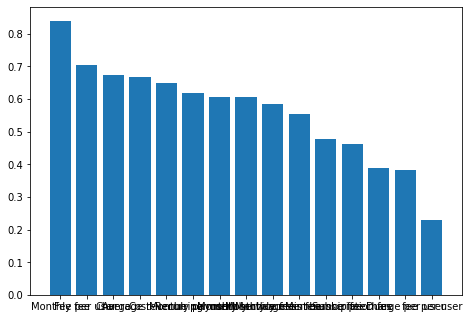

Mean similarity : 0.562646837035815


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.5727052688598633
label: number of users of the service 	 similarity: 0.5378708243370056
label: amount of people using the service 	 similarity: 0.5271288752555847
label: how many users does the service have 	 similarity: 0.5073962211608887
label: number of people using the service 	 similarity: 0.4917465150356293
label: how many people are using the service 	 similarity: 0.48440319299697876
label: users 	 similarity: 0.47768086194992065
label: 

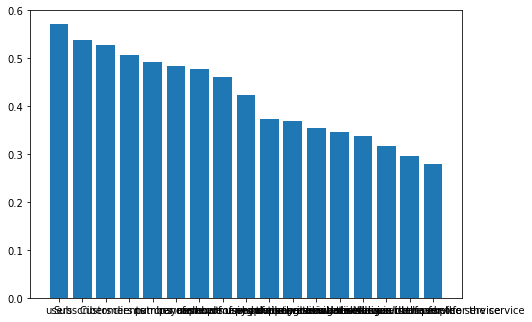

Mean similarity : 0.42109954883070555


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime value 	 similarity: 0.6803733110427856
label: Average customer lifetime 	 similarity: 0.6637082695960999
label: Median customer lifetime 	 similarity: 0.5876786112785339
label: Average client lifetime 	 similarity: 0.5856658220291138
label: Average length of customer life cycle 	 similarity: 0.5822446346282959
label: Customer attrition rate over time 	 similarity: 0.5425686240196228
label: Ordinary customer lifetime 	

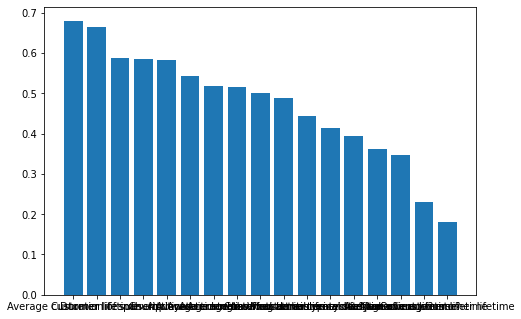

Mean similarity : 0.472826188101488


[0.562646837035815, 0.42109954883070555, 0.472826188101488]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  number of new subscribers per month
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Monthly payment 	 similarity: 0.47885385155677795
label: Recurring monthly charge 	 similarity: 0.42547711730003357
label: Monthly access fee 	 similarity: 0.41302284598350525
label: Monthly fee 	 similarity: 0.3779693841934204
label: Monthly maintenance fee 	 similarity: 0.3631075620651245
label: Monthly service fee 	 similarity: 0.35786470770835876
label: Dues 	 similarity: 0.3066306412220001
label: Average revenue per user 	 similarity: 0.2

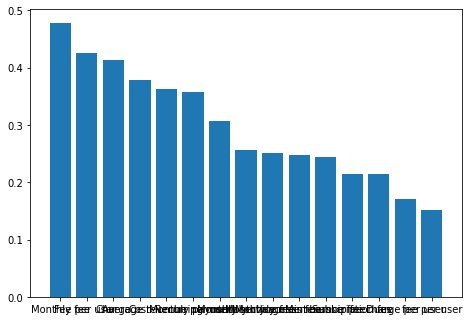

Mean similarity : 0.2981443325678507


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.5731251835823059
label: how many people are using the service 	 similarity: 0.5458868741989136
label: number of people using the service 	 similarity: 0.5386922955513
label: amount of people using the service 	 similarity: 0.5298503637313843
label: how many users does the service have 	 similarity: 0.528641939163208
label: number of users of the service 	 similarity: 0.5270042419433594
label: is the service used by a lot of people 	 similarity

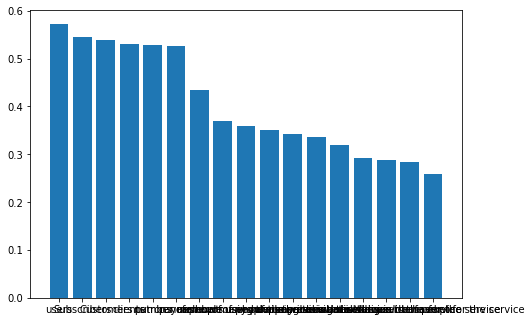

Mean similarity : 0.40447550486115846


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Customer attrition rate over time 	 similarity: 0.5215671062469482
label: staff turnover 	 similarity: 0.5184521675109863
label: employee turnover 	 similarity: 0.46998560428619385
label: Customer lifespan 	 similarity: 0.4419030547142029
label: Average client lifetime 	 similarity: 0.3730785846710205
label: What is the typical lifespan of a customer? 	 similarity: 0.37028300762176514
label: Average customer lifetime 	 similarity: 0.3575941324

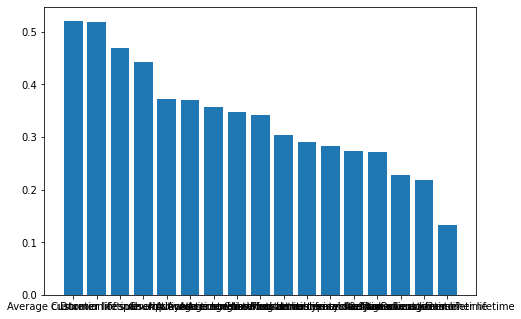

Mean similarity : 0.3378382386530147


[0.2981443325678507, 0.40447550486115846, 0.3378382386530147]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  estimated initial customers
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.5020147562026978
label: Monthly access fee 	 similarity: 0.4351591169834137
label: Monthly payment 	 similarity: 0.4322017729282379
label: Monthly service fee 	 similarity: 0.4224391281604767
label: Cost 	 similarity: 0.3820655345916748
label: fee per user 	 similarity: 0.37611308693885803
label: Fee per user  	 similarity: 0.37611308693885803
label: Monthly fee 	 similarity: 0.368126779794693
label: Dues 	 

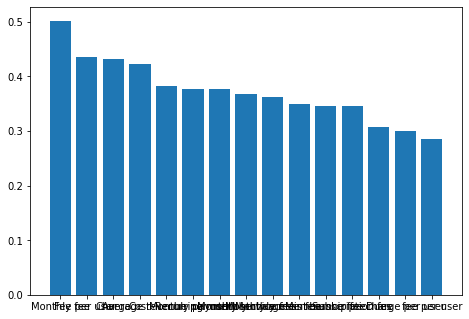

Mean similarity : 0.3724639594554901


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.6254326105117798
label: Customers 	 similarity: 0.5821813344955444
label: clients 	 similarity: 0.5571517944335938
label: number of people using the service 	 similarity: 0.511387825012207
label: amount of people using the service 	 similarity: 0.505138635635376
label: number of users of the service 	 similarity: 0.493954598903656
label: how many people are using the service 	 similarity: 0.4933003783226013
label: what is the user base for the

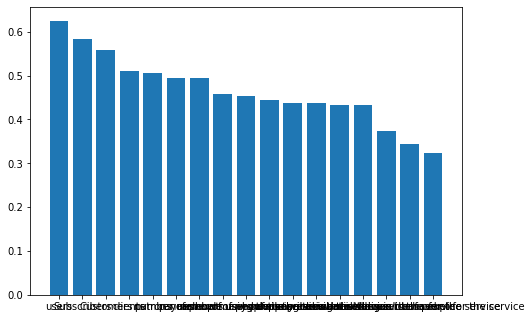

Mean similarity : 0.4649071430458742


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average customer lifetime 	 similarity: 0.6136788725852966
label: Average client lifetime 	 similarity: 0.588707447052002
label: Customer lifespan 	 similarity: 0.5839344263076782
label: Average customer lifetime value 	 similarity: 0.5800920724868774
label: Customer attrition rate over time 	 similarity: 0.5498061776161194
label: Median customer lifetime 	 similarity: 0.5402072072029114
label: Average length of customer life cycle 	 similarity

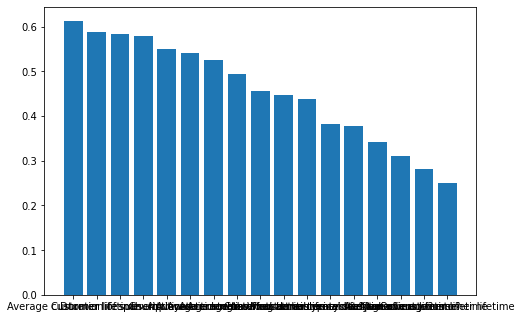

Mean similarity : 0.4564204023164861


[0.3724639594554901, 0.4649071430458742, 0.4564204023164861]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  number of new paying members
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Monthly payment 	 similarity: 0.542202353477478
label: Monthly access fee 	 similarity: 0.49127376079559326
label: Monthly service fee 	 similarity: 0.4599493443965912
label: Membership fee 	 similarity: 0.45882174372673035
label: Monthly fee 	 similarity: 0.45583444833755493
label: Recurring monthly charge 	 similarity: 0.4420967400074005
label: Dues 	 similarity: 0.42688825726509094
label: Subscription fee 	 similarity: 0.3883518874645233
label: 

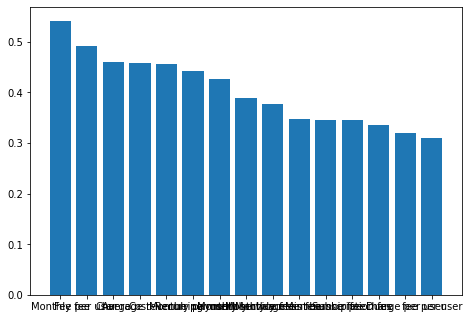

Mean similarity : 0.40309503078460696


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.6540696620941162
label: number of people using the service 	 similarity: 0.568356990814209
label: payees 	 similarity: 0.5588417053222656
label: amount of people using the service 	 similarity: 0.5562132000923157
label: number of users of the service 	 similarity: 0.5365150570869446
label: how many people are using the service 	 similarity: 0.5244970917701721
label: members 	 similarity: 0.5210488438606262
label: is the service used by a lot 

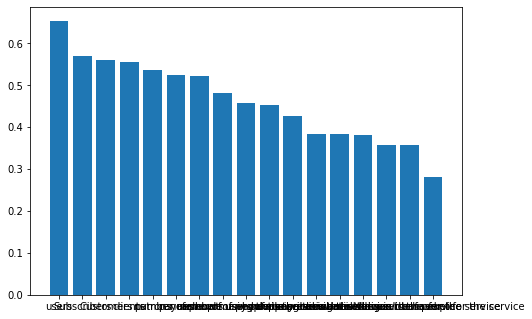

Mean similarity : 0.46384445358725157


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Customer attrition rate over time 	 similarity: 0.5547220706939697
label: staff turnover 	 similarity: 0.5444276332855225
label: employee turnover 	 similarity: 0.501789927482605
label: Attrition rates 	 similarity: 0.4577782452106476
label: Customer lifespan 	 similarity: 0.4252583086490631
label: Average client lifetime 	 similarity: 0.4217376410961151
label: Duration of subscription 	 similarity: 0.3880889117717743
label: Average customer l

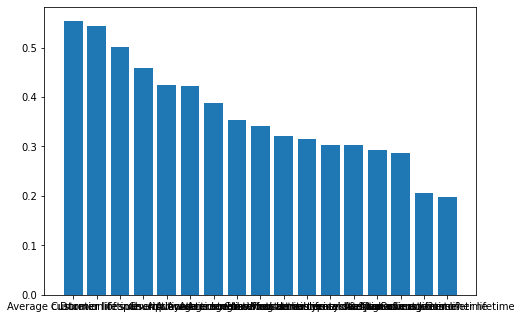

Mean similarity : 0.3654965398942723


[0.40309503078460696, 0.46384445358725157, 0.3654965398942723]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  average customer retention
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Average revenue per user 	 similarity: 0.5894717574119568
label: Monthly service fee 	 similarity: 0.3718877136707306
label: fee per user 	 similarity: 0.36667776107788086
label: Fee per user  	 similarity: 0.36667776107788086
label: Monthly maintenance fee 	 similarity: 0.3554273545742035
label: Monthly payment 	 similarity: 0.34947922825813293
label: Monthly access fee 	 similarity: 0.324496328830719
label: Monthly fee 	 similarity: 0.32266438007

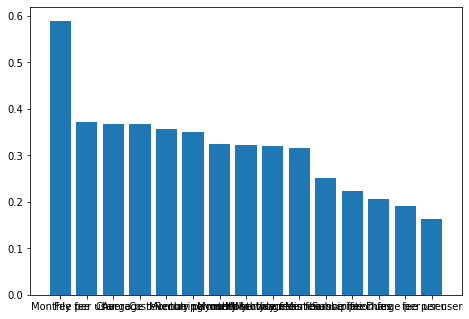

Mean similarity : 0.3143528878688812


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Customers 	 similarity: 0.5283600091934204
label: patrons 	 similarity: 0.47770464420318604
label: Subscribers 	 similarity: 0.45953404903411865
label: clients 	 similarity: 0.4375586211681366
label: how popular is the service 	 similarity: 0.43381041288375854
label: users 	 similarity: 0.41687291860580444
label: amount of people using the service 	 similarity: 0.41645821928977966
label: is the service used by a lot of people 	 similarity: 0.4113214612007141
label: payee

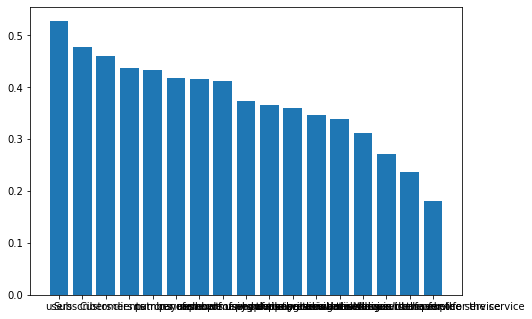

Mean similarity : 0.3746599853038788


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Average time customers remain active 	 similarity: 0.7730339169502258
label: Average customer lifetime 	 similarity: 0.7040154933929443
label: Average customer lifetime value 	 similarity: 0.6983709335327148
label: Average length of customer life cycle 	 similarity: 0.6736539602279663
label: Ordinary customer lifetime 	 similarity: 0.6437699794769287
label: Average client lifetime 	 similarity: 0.6406694650650024
label: Customer lifespan 	 simi

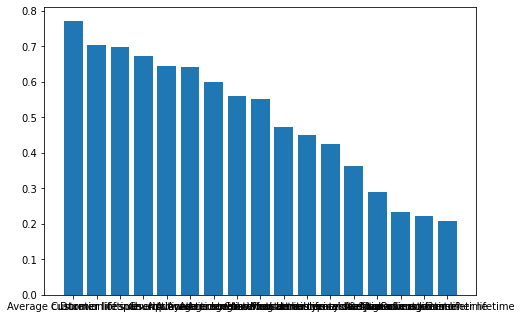

Mean similarity : 0.5004824969698402


[0.3143528878688812, 0.3746599853038788, 0.5004824969698402]
Predicted class :  3
------------------------------------------------------
----------Sentence similarity for :  projected users subscription length
--- Class labels :  ['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user']
label: Subscription fee 	 similarity: 0.6146925091743469
label: Monthly access fee 	 similarity: 0.5424755811691284
label: Membership fee 	 similarity: 0.5229056477546692
label: Monthly service fee 	 similarity: 0.4951552152633667
label: Average revenue per user 	 similarity: 0.47776147723197937
label: Cost 	 similarity: 0.47237202525138855
label: Monthly fee 	 similarity: 0.4562612771987915
label: charge per user 	 similarity: 0.454816609621048
la

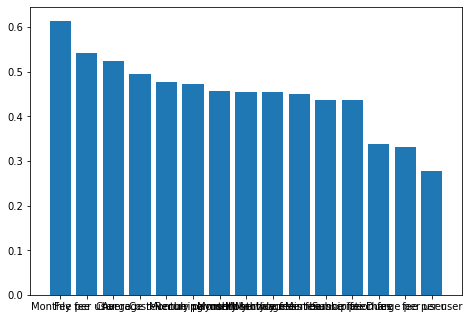

Mean similarity : 0.4504764715830485


--- Class labels :  ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service']
label: Subscribers 	 similarity: 0.5918636918067932
label: number of users of the service 	 similarity: 0.5769363045692444
label: how many users does the service have 	 similarity: 0.5398723483085632
label: number of people using the service 	 similarity: 0.5364397168159485
label: how many people are using the service 	 similarity: 0.5221517086029053
label: amount of people using the service 	 similarity: 0.5163862109184265
label: users 	 similarity: 0.4674775004386902
label: w

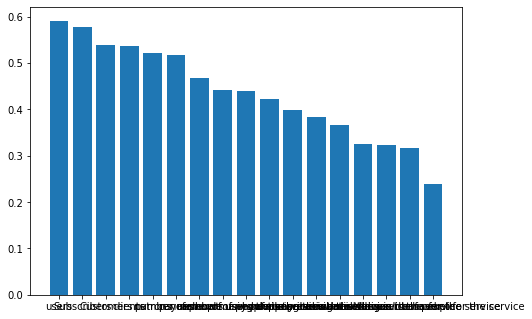

Mean similarity : 0.4358597143607981


--- Class labels :  ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'Customer attrition rate over time', 'How long do customers stay on average?', 'What is the typical lifespan of a customer?', 'staff turnover', 'Average client lifetime', 'Median customer lifetime', 'Ordinary customer lifetime']
label: Duration of subscription 	 similarity: 0.6908460259437561
label: Customer lifespan 	 similarity: 0.5933730006217957
label: Median customer lifetime 	 similarity: 0.5910043716430664
label: Average customer lifetime 	 similarity: 0.5591330528259277
label: Average client lifetime 	 similarity: 0.5484185814857483
label: Customer attrition rate over time 	 similarity: 0.5352304577827454
label: Average customer lifetime value 	 similarity: 0.49347051

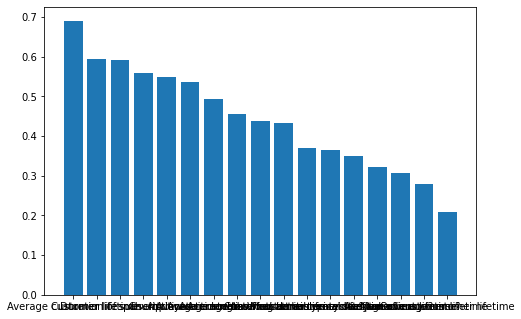

Mean similarity : 0.44352271188707915


[0.4504764715830485, 0.4358597143607981, 0.44352271188707915]
Predicted class :  1
------------------------------------------------------


In [19]:
# using BERT sentence encoding with cosine similarity
sentence_net = BERTencoding(sentences,labels)
predictions = cosineSimilarity(sentence_net, 0.4)

              precision    recall  f1-score   support

           1       1.00      0.30      0.46        10
           2       0.75      1.00      0.86         3
           3       0.50      1.00      0.67         1
           4       0.29      1.00      0.44         2

    accuracy                           0.56        16
   macro avg       0.63      0.82      0.61        16
weighted avg       0.83      0.56      0.55        16



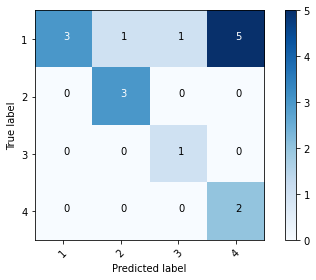

In [22]:
report = evaluation(predictions, class_labels)

In [39]:
torch.mean(sentence_net[0]['encodings'][0]['label_reps'])

tensor(-0.0163, grad_fn=<MeanBackward0>)

In [44]:
f = F.cosine_similarity(sentence_net[0]['encodings'][0]["sentence_rep"], torch.mean(sentence_net[0]['encodings'][0]['label_reps']))
float(f)

0.02916453406214714

In [30]:
predictions = BERTCrossEncoder(sentences, labels)

Sentence --> Annual recurring revenue
Monthly fee [{'label': 'LABEL_0', 'score': 0.5812486410140991}]
Fee per user  [{'label': 'LABEL_0', 'score': 0.008607344701886177}]
Charge [{'label': 'LABEL_0', 'score': 0.2989566922187805}]
Cost [{'label': 'LABEL_0', 'score': 0.7371387481689453}]
Average revenue per user [{'label': 'LABEL_0', 'score': 0.012703102082014084}]
Monthly payment [{'label': 'LABEL_0', 'score': 0.7724791765213013}]
Recurring monthly charge [{'label': 'LABEL_0', 'score': 0.0851794183254242}]
Monthly service fee [{'label': 'LABEL_0', 'score': 0.8036442995071411}]
Monthly access fee [{'label': 'LABEL_0', 'score': 0.03683662414550781}]
Monthly maintenance fee [{'label': 'LABEL_0', 'score': 0.875948429107666}]
Membership fee [{'label': 'LABEL_0', 'score': 0.5439927577972412}]
Subscription fee [{'label': 'LABEL_0', 'score': 0.13402868807315826}]
Dues [{'label': 'LABEL_0', 'score': 0.3638465106487274}]
charge per user [{'label': 'LABEL_0', 'score': 0.016220903024077415}]
fee per

Dues [{'label': 'LABEL_0', 'score': 0.011120036244392395}]
charge per user [{'label': 'LABEL_0', 'score': 0.007094758562743664}]
fee per user [{'label': 'LABEL_0', 'score': 0.0037543969228863716}]
users [{'label': 'LABEL_0', 'score': 0.0051663583144545555}]
Subscribers [{'label': 'LABEL_0', 'score': 0.0048216586001217365}]
Customers [{'label': 'LABEL_0', 'score': 0.009725581854581833}]
clients [{'label': 'LABEL_0', 'score': 0.013943052850663662}]
patrons [{'label': 'LABEL_0', 'score': 0.007273674011230469}]
payees [{'label': 'LABEL_0', 'score': 0.005640736781060696}]
members [{'label': 'LABEL_0', 'score': 0.004823436960577965}]
number of people using the service [{'label': 'LABEL_0', 'score': 0.005469051655381918}]
number of users of the service [{'label': 'LABEL_0', 'score': 0.004554816521704197}]
amount of people using the service [{'label': 'LABEL_0', 'score': 0.005061914678663015}]
how many people are using the service [{'label': 'LABEL_0', 'score': 0.001040048897266388}]
how popul

how many people are using the service [{'label': 'LABEL_0', 'score': 0.0034774867817759514}]
how popular is the service [{'label': 'LABEL_0', 'score': 0.06688293814659119}]
how many users does the service have [{'label': 'LABEL_0', 'score': 0.007695483509451151}]
is the service used by a lot of people [{'label': 'LABEL_0', 'score': 0.0026641960721462965}]
how well-known is the service [{'label': 'LABEL_0', 'score': 0.0032044430263340473}]
what is the user base for the service [{'label': 'LABEL_0', 'score': 0.006985003594309092}]
how big is the market for the service [{'label': 'LABEL_0', 'score': 0.002530517987906933}]
Average customer lifetime [{'label': 'LABEL_0', 'score': 0.016787409782409668}]
Customer lifespan [{'label': 'LABEL_0', 'score': 0.5539292097091675}]
Duration of subscription [{'label': 'LABEL_0', 'score': 0.1606169193983078}]
Churn [{'label': 'LABEL_0', 'score': 0.2043234258890152}]
Attrition [{'label': 'LABEL_0', 'score': 0.9833184480667114}]
employee turnover [{'label

Customer lifespan [{'label': 'LABEL_0', 'score': 0.9687613248825073}]
Duration of subscription [{'label': 'LABEL_0', 'score': 0.982284426689148}]
Churn [{'label': 'LABEL_0', 'score': 0.09594613313674927}]
Attrition [{'label': 'LABEL_0', 'score': 0.9811270833015442}]
employee turnover [{'label': 'LABEL_0', 'score': 0.943020761013031}]
Attrition rates [{'label': 'LABEL_0', 'score': 0.9472353458404541}]
Average customer lifetime value [{'label': 'LABEL_0', 'score': 0.5533617734909058}]
Average length of customer life cycle [{'label': 'LABEL_0', 'score': 0.1671692430973053}]
Average time customers remain active [{'label': 'LABEL_0', 'score': 0.02215469628572464}]
Customer attrition rate over time [{'label': 'LABEL_0', 'score': 0.7281926870346069}]
How long do customers stay on average? [{'label': 'LABEL_0', 'score': 0.00810238253325224}]
What is the typical lifespan of a customer? [{'label': 'LABEL_0', 'score': 0.0020924480631947517}]
staff turnover [{'label': 'LABEL_0', 'score': 0.9802450

staff turnover [{'label': 'LABEL_0', 'score': 0.03670952469110489}]
Average client lifetime [{'label': 'LABEL_0', 'score': 0.007716047111898661}]
Median customer lifetime [{'label': 'LABEL_0', 'score': 0.0030236621387302876}]
Ordinary customer lifetime [{'label': 'LABEL_0', 'score': 0.00404901010915637}]
[0.28024005903862415, 0.042054699398303294, 0.5437990625950453]
Sentence --> revenue per user
Monthly fee [{'label': 'LABEL_0', 'score': 0.3684060275554657}]
Fee per user  [{'label': 'LABEL_0', 'score': 0.022635892033576965}]
Charge [{'label': 'LABEL_0', 'score': 0.7824609875679016}]
Cost [{'label': 'LABEL_0', 'score': 0.9555740356445312}]
Average revenue per user [{'label': 'LABEL_0', 'score': 0.8121796250343323}]
Monthly payment [{'label': 'LABEL_0', 'score': 0.1169700175523758}]
Recurring monthly charge [{'label': 'LABEL_0', 'score': 0.02532036602497101}]
Monthly service fee [{'label': 'LABEL_0', 'score': 0.0488881915807724}]
Monthly access fee [{'label': 'LABEL_0', 'score': 0.18914

Monthly access fee [{'label': 'LABEL_0', 'score': 0.005372030660510063}]
Monthly maintenance fee [{'label': 'LABEL_0', 'score': 0.01391710713505745}]
Membership fee [{'label': 'LABEL_0', 'score': 0.0035729750525206327}]
Subscription fee [{'label': 'LABEL_0', 'score': 0.0028049254324287176}]
Dues [{'label': 'LABEL_0', 'score': 0.0037668754812330008}]
charge per user [{'label': 'LABEL_0', 'score': 0.0011015943018719554}]
fee per user [{'label': 'LABEL_0', 'score': 0.0016124786343425512}]
users [{'label': 'LABEL_0', 'score': 0.0020350455306470394}]
Subscribers [{'label': 'LABEL_0', 'score': 0.00199176836758852}]
Customers [{'label': 'LABEL_0', 'score': 0.0028023712802678347}]
clients [{'label': 'LABEL_0', 'score': 0.001349722733721137}]
patrons [{'label': 'LABEL_0', 'score': 0.001462784712202847}]
payees [{'label': 'LABEL_0', 'score': 0.0032536524813622236}]
members [{'label': 'LABEL_0', 'score': 0.0021571603137999773}]
number of people using the service [{'label': 'LABEL_0', 'score': 0.0

Customers [{'label': 'LABEL_0', 'score': 0.006156678777188063}]
clients [{'label': 'LABEL_0', 'score': 0.010218014940619469}]
patrons [{'label': 'LABEL_0', 'score': 0.016107551753520966}]
payees [{'label': 'LABEL_0', 'score': 0.009651370346546173}]
members [{'label': 'LABEL_0', 'score': 0.0016520944191142917}]
number of people using the service [{'label': 'LABEL_0', 'score': 0.0027246521785855293}]
number of users of the service [{'label': 'LABEL_0', 'score': 0.005742569454014301}]
amount of people using the service [{'label': 'LABEL_0', 'score': 0.0029322821646928787}]
how many people are using the service [{'label': 'LABEL_0', 'score': 0.0010506130056455731}]
how popular is the service [{'label': 'LABEL_0', 'score': 0.001301835640333593}]
how many users does the service have [{'label': 'LABEL_0', 'score': 0.0014927427982911468}]
is the service used by a lot of people [{'label': 'LABEL_0', 'score': 0.0009081898024305701}]
how well-known is the service [{'label': 'LABEL_0', 'score': 0.

how many people are using the service [{'label': 'LABEL_0', 'score': 0.0009391185594722629}]
how popular is the service [{'label': 'LABEL_0', 'score': 0.0010898280888795853}]
how many users does the service have [{'label': 'LABEL_0', 'score': 0.0019785468466579914}]
is the service used by a lot of people [{'label': 'LABEL_0', 'score': 0.0007701826980337501}]
how well-known is the service [{'label': 'LABEL_0', 'score': 0.000973033718764782}]
what is the user base for the service [{'label': 'LABEL_0', 'score': 0.0008793179295025766}]
how big is the market for the service [{'label': 'LABEL_0', 'score': 0.0009726138669066131}]
Average customer lifetime [{'label': 'LABEL_0', 'score': 0.007009976077824831}]
Customer lifespan [{'label': 'LABEL_0', 'score': 0.05352334305644035}]
Duration of subscription [{'label': 'LABEL_0', 'score': 0.1875172257423401}]
Churn [{'label': 'LABEL_0', 'score': 0.012943200767040253}]
Attrition [{'label': 'LABEL_0', 'score': 0.027778327465057373}]
employee turnover

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.29      0.25      0.27         8

    accuracy                           0.12        16
   macro avg       0.07      0.06      0.07        16
weighted avg       0.14      0.12      0.13        16



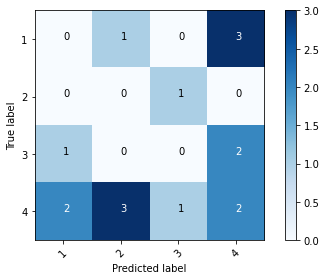

In [31]:
evaluation(predictions, class_labels)

# Interview Question

In [32]:
# unfiltered data
# label1 = ['Make sure questions are easy to understand','Make sure questions are easy to direct','Make sure questions are easy to straightforward','Use short questions','Use succinct questions','Use clear questions','Avoid questions that are too long']
# label2 = ['Keep questions open ended','Do not ask yes/no questions','Do not ask closed questions','Do not ask leading questions','Avoid questions that suggest the answer you want',"Don't ask directly what they want"]
# label3 = ['Have a logical structure to the questions','Questions should flow from one to the other','Questions should be sequenced in a natural way','Warm up before going into the detailed questions','Start with some easier questions to help them relax','Prepare your questions beforehand']
# labels = [label1, label2, label3]

In [26]:
label1 = ['easy understand','easy direct','easy straightforward','short','succinct','clear','Avoid too long']
label2 = ['open ended','Do not ask yes/no','Do not ask closed','Do not ask leading','Avoid suggest answer you want',"Don't ask directly"]
label3 = ['logical structure','flow one to other','sequenced natural way','Warm up before detailed','Start easier to relax','Prepare beforehand']
labels = [label1, label2, label3]

In [21]:
label1 = ['Easy','Easy to understand','Make sure questions are easy to understand','Make sure questions are easy to direct','Make sure questions are easy to straightforward','Use short questions','Use succinct questions','Use clear questions','Easy to grasp','Easy to comprehend','Easy to follow','Simple to understand','straightforward to understand','Effortless to understand','Clear to understand','Lucid to understand','Plain to understand','Obvious to understand']
label2 = ['Open','Open ended','Keep questions open ended','Do not ask yes/no questions','Do not ask closed questions','Do not ask leading questions','Avoid questions that suggest the answer you want','Do not ask directly what they want','unstructured','free-form','without limits','without boundaries','without restrictions','unconstrained','opinion based','unconfined','unrestrained','subjective']
label3 = ['Structured','well designed','Have a logical structure to the questions','Questions should flow from one to the other','Questions should be sequenced in a natural way','Warm up before going into the detailed questions','Start with questions which buid up to other questions','Prepare your questions beforehand','Be aware of the order in which you ask your questions.','Make sure your questions have a clear purpose.','Develop a system for organizing your questions.','Ask questions that are clear and concise.','Be sure your questions are relevant to the topic','Make sure your questions are specific','well-organized','systematic structure','coherent ','well-planned']
labels = [label1, label2, label3]

In [27]:
sentences = {
    'questions are easily understandable':1,
    'questions are not closed ':2,
    'questions are open to interpretation':2,
    'questions have a logical flow':3,
    'questions are followed up by apropriate follow up questions':3,
    'questions are brief and easy to understand':1
}

In [28]:
labels = [label1, label2, label3]
class_labels = []
for key, value in sentences.items():
    class_labels.append(value)

/opt/homebrew/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2301: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


----------Sentence similarity for :  questions are easily understandable
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy understand 	 similarity: 0.6703381538391113
label: easy direct 	 similarity: 0.6420934200286865
label: easy straightforward 	 similarity: 0.5611382126808167
label: clear 	 similarity: 0.4958990216255188
label: succinct 	 similarity: 0.45353469252586365
label: short 	 similarity: 0.18743547797203064
label: Avoid too long 	 similarity: 0.04380325227975845


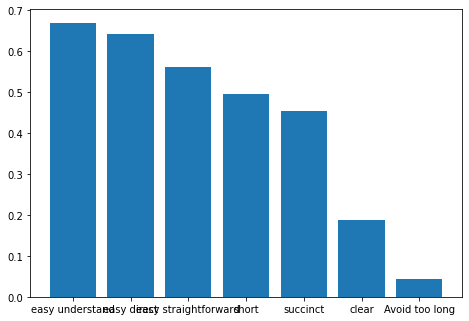

Mean similarity : 0.436320318707398


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.17659004032611847
label: Do not ask closed 	 similarity: 0.10489607602357864
label: Don't ask directly 	 similarity: 0.09543244540691376
label: Do not ask leading 	 similarity: 0.08675151318311691
label: Avoid suggest answer you want 	 similarity: 0.04967650771141052
label: Do not ask yes/no 	 similarity: -0.017100602388381958


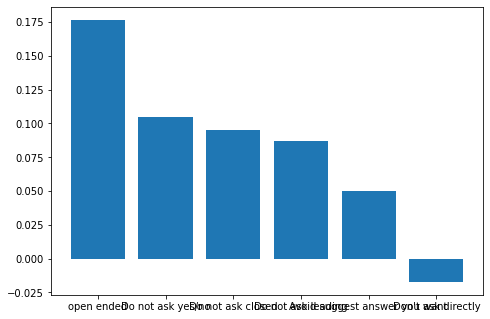

Mean similarity : 0.08270766337712605


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.5112177729606628
label: Start easier to relax 	 similarity: 0.42492181062698364
label: Warm up before detailed 	 similarity: 0.3166806995868683
label: sequenced natural way 	 similarity: 0.300115168094635
label: flow one to other 	 similarity: 0.22237913310527802
label: Prepare beforehand 	 similarity: 0.16873590648174286


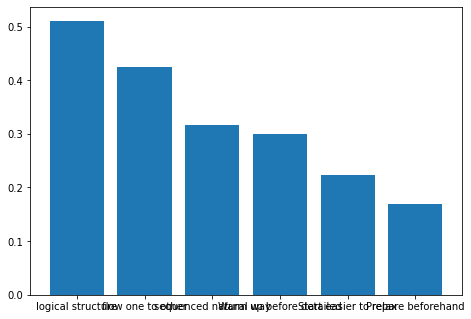

Mean similarity : 0.3240084151426951


[0.436320318707398, 0.08270766337712605, 0.3240084151426951]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are not closed 
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: clear 	 similarity: 0.4633898437023163
label: easy understand 	 similarity: 0.4106239378452301
label: easy direct 	 similarity: 0.4016709327697754
label: easy straightforward 	 similarity: 0.3863743543624878
label: succinct 	 similarity: 0.35172009468078613
label: short 	 similarity: 0.17287582159042358
label: Avoid too long 	 similarity: 0.16260018944740295


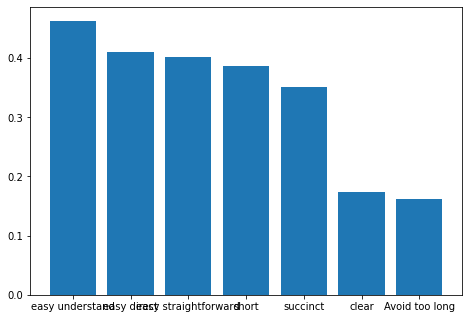

Mean similarity : 0.33560788205691744


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask closed 	 similarity: 0.6720290780067444
label: Do not ask leading 	 similarity: 0.4705021381378174
label: Don't ask directly 	 similarity: 0.4613420069217682
label: Do not ask yes/no 	 similarity: 0.32136744260787964
label: Avoid suggest answer you want 	 similarity: 0.30181363224983215
label: open ended 	 similarity: 0.27715542912483215


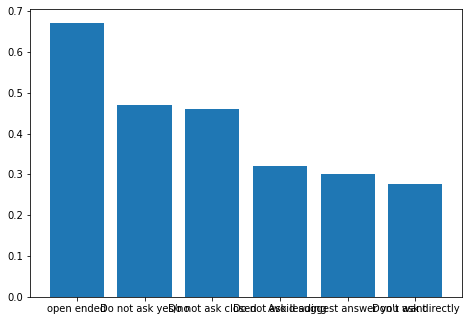

Mean similarity : 0.417368287841479


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.3790018558502197
label: flow one to other 	 similarity: 0.3375738263130188
label: Warm up before detailed 	 similarity: 0.26810234785079956
label: Start easier to relax 	 similarity: 0.2493179887533188
label: sequenced natural way 	 similarity: 0.2157585322856903
label: Prepare beforehand 	 similarity: 0.18410031497478485


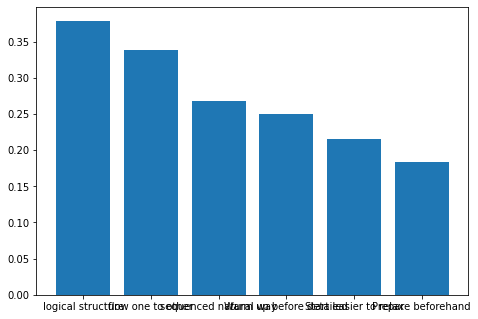

Mean similarity : 0.272309144337972


[0.33560788205691744, 0.417368287841479, 0.272309144337972]
Predicted class :  2
------------------------------------------------------
----------Sentence similarity for :  questions are open to interpretation
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.4465622901916504
label: clear 	 similarity: 0.4328763782978058
label: easy understand 	 similarity: 0.431896448135376
label: succinct 	 similarity: 0.4149993062019348
label: easy straightforward 	 similarity: 0.33575162291526794
label: short 	 similarity: 0.14835742115974426
label: Avoid too long 	 similarity: 0.1031683087348938


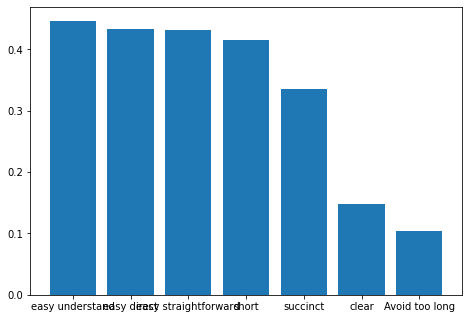

Mean similarity : 0.3305159679480961


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: open ended 	 similarity: 0.34054431319236755
label: Do not ask closed 	 similarity: 0.2575043737888336
label: Avoid suggest answer you want 	 similarity: 0.24897310137748718
label: Don't ask directly 	 similarity: 0.24801908433437347
label: Do not ask leading 	 similarity: 0.2134089469909668
label: Do not ask yes/no 	 similarity: 0.14593814313411713


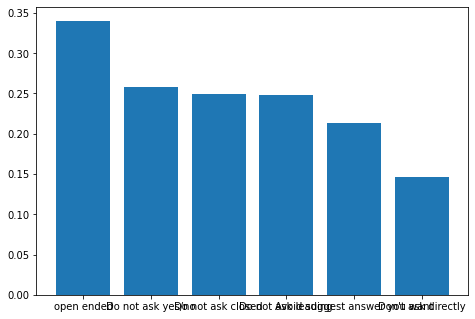

Mean similarity : 0.2423979938030243


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.4230130612850189
label: sequenced natural way 	 similarity: 0.31824931502342224
label: flow one to other 	 similarity: 0.3056386411190033
label: Warm up before detailed 	 similarity: 0.2950313091278076
label: Start easier to relax 	 similarity: 0.2592749297618866
label: Prepare beforehand 	 similarity: 0.25036337971687317


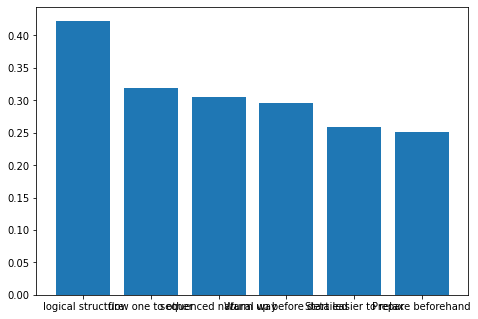

Mean similarity : 0.30859510600566864


[0.3305159679480961, 0.2423979938030243, 0.30859510600566864]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions have a logical flow
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy direct 	 similarity: 0.6051760911941528
label: easy understand 	 similarity: 0.5956115126609802
label: easy straightforward 	 similarity: 0.5328835248947144
label: clear 	 similarity: 0.5318057537078857
label: succinct 	 similarity: 0.4856983423233032
label: short 	 similarity: 0.1842961311340332
label: Avoid too long 	 similarity: 0.08078145980834961


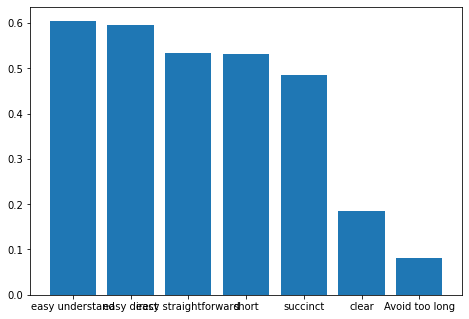

Mean similarity : 0.43089325938905987


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.1946108192205429
label: Don't ask directly 	 similarity: 0.18962398171424866
label: Do not ask closed 	 similarity: 0.18319593369960785
label: open ended 	 similarity: 0.155120849609375
label: Avoid suggest answer you want 	 similarity: 0.11332828551530838
label: Do not ask yes/no 	 similarity: 0.0620887316763401


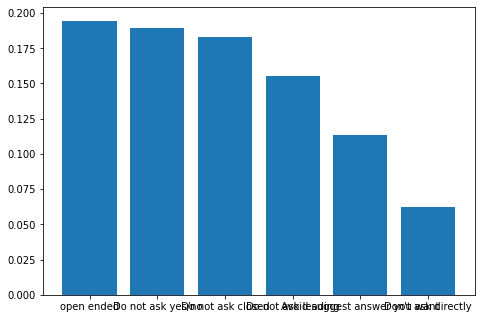

Mean similarity : 0.14966143357257047


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: logical structure 	 similarity: 0.7144714593887329
label: Start easier to relax 	 similarity: 0.3677491545677185
label: sequenced natural way 	 similarity: 0.34551841020584106
label: flow one to other 	 similarity: 0.2951914668083191
label: Warm up before detailed 	 similarity: 0.29153499007225037
label: Prepare beforehand 	 similarity: 0.23784461617469788


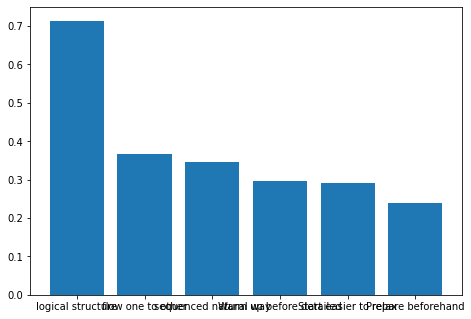

Mean similarity : 0.37538501620292664


[0.43089325938905987, 0.14966143357257047, 0.37538501620292664]
Predicted class :  1
------------------------------------------------------
----------Sentence similarity for :  questions are followed up by apropriate follow up questions
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: succinct 	 similarity: 0.152955561876297
label: clear 	 similarity: 0.10316088050603867
label: Avoid too long 	 similarity: 0.09882790595293045
label: easy direct 	 similarity: 0.08966555446386337
label: easy understand 	 similarity: 0.08520388603210449
label: short 	 similarity: 0.04360242560505867
label: easy straightforward 	 similarity: 0.020214321091771126


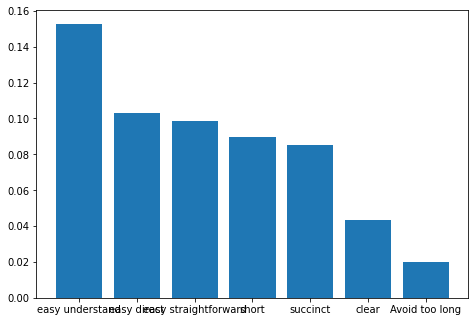

Mean similarity : 0.08480436221829482


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Avoid suggest answer you want 	 similarity: 0.28482311964035034
label: Don't ask directly 	 similarity: 0.27720388770103455
label: open ended 	 similarity: 0.16582649946212769
label: Do not ask closed 	 similarity: 0.16237668693065643
label: Do not ask yes/no 	 similarity: 0.14362461864948273
label: Do not ask leading 	 similarity: 0.13512352108955383


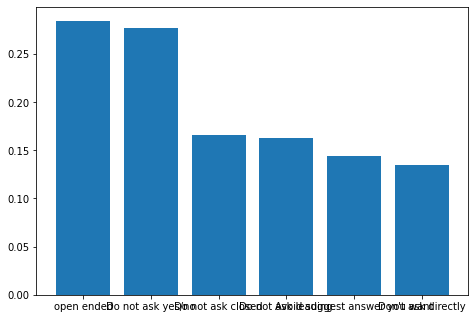

Mean similarity : 0.19482972224553427


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Prepare beforehand 	 similarity: 0.4461742341518402
label: Warm up before detailed 	 similarity: 0.34180015325546265
label: sequenced natural way 	 similarity: 0.26198920607566833
label: flow one to other 	 similarity: 0.2579571008682251
label: logical structure 	 similarity: 0.1778418868780136
label: Start easier to relax 	 similarity: 0.16352932155132294


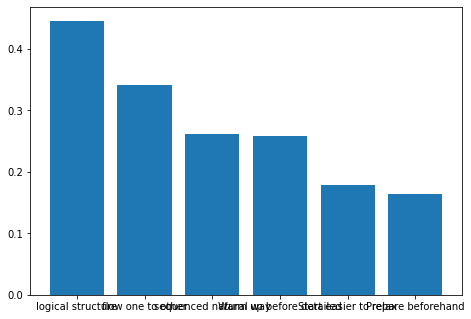

Mean similarity : 0.2748819837967555


[0.08480436221829482, 0.19482972224553427, 0.2748819837967555]
Predicted class :  4
------------------------------------------------------
----------Sentence similarity for :  questions are brief and easy to understand
--- Class labels :  ['easy understand', 'easy direct', 'easy straightforward', 'short', 'succinct', 'clear', 'Avoid too long']
label: easy straightforward 	 similarity: 0.773331344127655
label: easy understand 	 similarity: 0.7590068578720093
label: easy direct 	 similarity: 0.6342107057571411
label: succinct 	 similarity: 0.5687748789787292
label: short 	 similarity: 0.5665718913078308
label: clear 	 similarity: 0.4344612658023834
label: Avoid too long 	 similarity: 0.20800313353538513


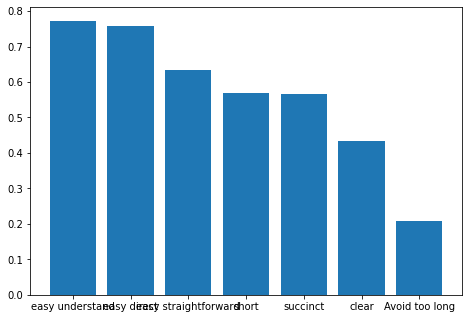

Mean similarity : 0.5634800110544477


--- Class labels :  ['open ended', 'Do not ask yes/no', 'Do not ask closed', 'Do not ask leading', 'Avoid suggest answer you want', "Don't ask directly"]
label: Do not ask leading 	 similarity: 0.25441691279411316
label: Do not ask closed 	 similarity: 0.22169482707977295
label: open ended 	 similarity: 0.18783344328403473
label: Avoid suggest answer you want 	 similarity: 0.17104610800743103
label: Do not ask yes/no 	 similarity: 0.14123602211475372
label: Don't ask directly 	 similarity: 0.13568177819252014


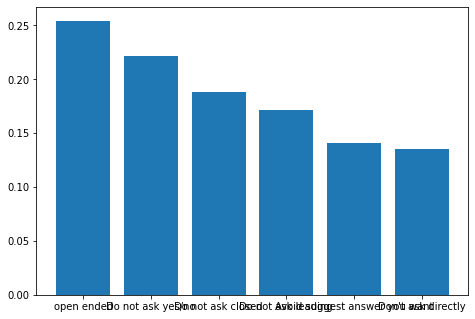

Mean similarity : 0.18531818191210428


--- Class labels :  ['logical structure', 'flow one to other', 'sequenced natural way', 'Warm up before detailed', 'Start easier to relax', 'Prepare beforehand']
label: Start easier to relax 	 similarity: 0.516423225402832
label: logical structure 	 similarity: 0.311419814825058
label: Warm up before detailed 	 similarity: 0.22864916920661926
label: flow one to other 	 similarity: 0.16083262860774994
label: sequenced natural way 	 similarity: 0.13828566670417786
label: Prepare beforehand 	 similarity: -0.00013722479343414307


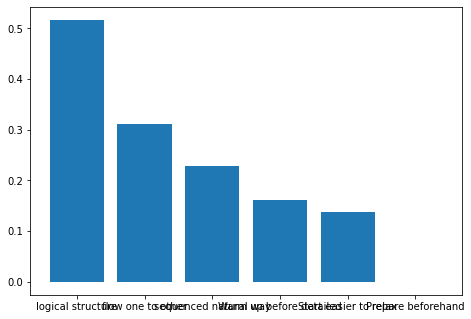

Mean similarity : 0.2259122133255005


[0.5634800110544477, 0.18531818191210428, 0.2259122133255005]
Predicted class :  1
------------------------------------------------------


In [29]:
# using BERT sentence encoding with cosine similarity
sentence_net = BERTencoding(sentences,labels)
predictions = cosineSimilarity(sentence_net, 0.4)

Accuracy  0.5
              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         2

    accuracy                           0.50         6
   macro avg       0.38      0.42      0.37         6
weighted avg       0.58      0.50      0.51         6



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classif

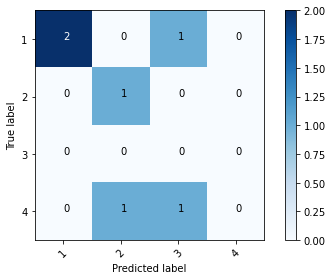

In [30]:
evaluation(predictions, class_labels)

In [38]:
predictions = BERTCrossEncoder(sentences, labels)

Sentence --> questions are easily understandable
Make sure questions are easy to understand [{'label': 'LABEL_0', 'score': 0.9816793203353882}]
Make sure questions are easy to direct [{'label': 'LABEL_0', 'score': 0.9866750836372375}]
Make sure questions are easy to straightforward [{'label': 'LABEL_0', 'score': 0.9759017825126648}]
Use short questions [{'label': 'LABEL_0', 'score': 0.9574682116508484}]
Use succinct questions [{'label': 'LABEL_0', 'score': 0.9700797200202942}]
Use clear questions [{'label': 'LABEL_0', 'score': 0.98948073387146}]
Avoid questions that are too long [{'label': 'LABEL_0', 'score': 0.9073525071144104}]
Keep questions open ended [{'label': 'LABEL_0', 'score': 0.9369443655014038}]
Do not ask yes/no questions [{'label': 'LABEL_0', 'score': 0.9639422297477722}]
Do not ask closed questions [{'label': 'LABEL_0', 'score': 0.856592059135437}]
Do not ask leading questions [{'label': 'LABEL_0', 'score': 0.9640817046165466}]
Avoid questions that suggest the answer you 

Start with some easier questions to help them relax [{'label': 'LABEL_0', 'score': 0.01647423952817917}]
Prepare your questions beforehand [{'label': 'LABEL_0', 'score': 0.9454675912857056}]
[1.3984258213479603, 0.2956160996109247, 1.479994091205299]
Sentence --> questions are brief and easy to understand
Make sure questions are easy to understand [{'label': 'LABEL_0', 'score': 0.0352611280977726}]
Make sure questions are easy to direct [{'label': 'LABEL_0', 'score': 0.3041799068450928}]
Make sure questions are easy to straightforward [{'label': 'LABEL_0', 'score': 0.8622362613677979}]
Use short questions [{'label': 'LABEL_0', 'score': 0.982413649559021}]
Use succinct questions [{'label': 'LABEL_0', 'score': 0.99420565366745}]
Use clear questions [{'label': 'LABEL_0', 'score': 0.9937135577201843}]
Avoid questions that are too long [{'label': 'LABEL_0', 'score': 0.4412567615509033}]
Keep questions open ended [{'label': 'LABEL_0', 'score': 0.9762523174285889}]
Do not ask yes/no questions

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.50      1.00      0.67         1
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67         6
   macro avg       0.50      0.62      0.50         6
weighted avg       0.83      0.67      0.67         6



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classif

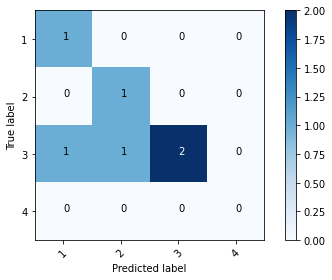

In [39]:
evaluation(predictions, class_labels)

In [40]:
predictions = BERTCosinePrediction(sentences, labels)

NameError: name 'torch' is not defined

              precision    recall  f1-score   support

           1       0.50      1.00      0.67         1
           2       0.50      1.00      0.67         1
           3       1.00      0.50      0.67         4
           4       0.00      0.00      0.00         0

   micro avg       0.67      0.67      0.67         6
   macro avg       0.50      0.62      0.50         6
weighted avg       0.83      0.67      0.67         6



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classif

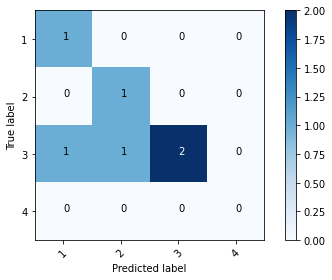

In [41]:
evaluation(predictions, class_labels)

In [4]:
print(labels)

[['Monthly fee', 'Fee per user ', 'Charge', 'Cost', 'Average revenue per user', 'Monthly payment', 'Recurring monthly charge', 'Monthly service fee', 'Monthly access fee', 'Monthly maintenance fee', 'Membership fee', 'Subscription fee', 'Dues', 'charge per user', 'fee per user'], ['users', 'Subscribers', 'Customers', 'clients', 'patrons', 'payees', 'members', 'number of people using the service', 'number of users of the service', 'amount of people using the service', 'how many people are using the service', 'how popular is the service', 'how many users does the service have', 'is the service used by a lot of people', 'how well-known is the service', 'what is the user base for the service', 'how big is the market for the service'], ['Average customer lifetime', 'Customer lifespan', 'Duration of subscription', 'Churn', 'Attrition', 'employee turnover', 'Attrition rates', 'Average customer lifetime value', 'Average length of customer life cycle', 'Average time customers remain active', 'C